In [49]:
%pylab inline
from sklearn.cluster import AgglomerativeClustering
import scipy.stats
import sklearn.decomposition

Populating the interactive namespace from numpy and matplotlib


In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats

#strdata = pd.read_csv("/storage/mgymrek/ssc-imputation/pilot-haplotypes/atxn7_haplotypes.tab", sep="\t")
#strdata = pd.read_csv("/storage/mgymrek/ssc-imputation/pilot-haplotypes/dmpk_haplotypes.tab", sep="\t")
#strdata = pd.read_csv("/storage/mgymrek/ssc-imputation/pilot-haplotypes/atxn7_haplotypes_fm.tab", sep="\t")
#snppos = [int(line.strip()) for line in open("/storage/mgymrek/ssc-imputation/pilot-haplotypes/atxn7_snppos.txt", "r").readlines()]
strdata = pd.read_csv("/storage/mgymrek/ssc-imputation/pilot-haplotypes2/pentaD_haplotypes.tab", sep="\t")
parents = [line.strip() for line in open("/home/mgymrek/workspace/ssc-imputation/metadata/ssc_parent_ids.txt", "r").readlines()]

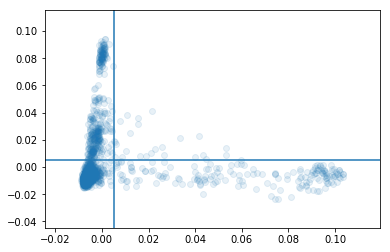

In [30]:
# Load PCA data
pca = pd.read_csv("/storage/s1saini/ssc-pca/pca_10.eigenvec", sep=" ", names=["sample","sample1","pc1","pc2"], usecols=range(4))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pca["pc1"],pca["pc2"], alpha=0.1)
ax.axhline(y=0.005)
ax.axvline(x=0.005)

In [32]:
strdata = strdata.sort("STRallele")
strdata["sample"] = strdata["sample-hap"].apply(lambda x: x.split("-")[0])
pdata = pd.DataFrame({"sample": parents})

# Merge with parents only
strdata = pd.merge(strdata, pdata, on=["sample"])

# Restrict to European samples
eur = pca[(pca["pc1"]<=0.005) & (pca["pc2"]<=0.005)]
strdata = pd.merge(strdata, pca[["sample"]], on=["sample"])

# Remove things with very low MAF
MINMAF = 0.01
ind_to_rm = []
numsnps = len(strdata["SNPhaplotype"].values[0])
for i in range(numsnps):
    snpgt = list(strdata["SNPhaplotype"].apply(lambda x: int(x[i])))
    maf = np.mean(snpgt)
    if maf < MINMAF or maf > (1-MINMAF): ind_to_rm.append(i)
strdata["SNPhaplotype"] = strdata["SNPhaplotype"].apply(lambda x: "".join([x[i] for i in range(len(x)) if i not in ind_to_rm]))

strdata.head()

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,sample-hap,STRallele,SNPhaplotype,sample
0,SSC02892-hap2,25,0000000000000000000000000001000000000010000000...,SSC02892
1,SSC02892-hap1,27,0100010101101011001101000000001111011001101001...,SSC02892
2,SSC04658-hap2,25,0100110111101011001101000000001111010011101001...,SSC04658
3,SSC04658-hap1,26,0100010101101011001101000000001111011011101001...,SSC04658
4,SSC09878-hap2,26,0100110111101011011101000000011111010011101001...,SSC09878


In [20]:
def ClusterRows(hapmatrix, nclusters=6):
    c = AgglomerativeClustering(n_clusters=min([hapmatrix.shape[0], nclusters]))
    labels = c.fit_predict(hapmatrix)
    idx = sorted([(labels[i], i) for i in range(hapmatrix.shape[0])])
    neworder = [item[1] for item in idx]
    return hapmatrix[neworder,:], neworder, [item[0] for item in idx]

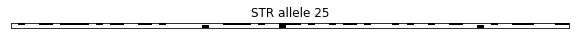

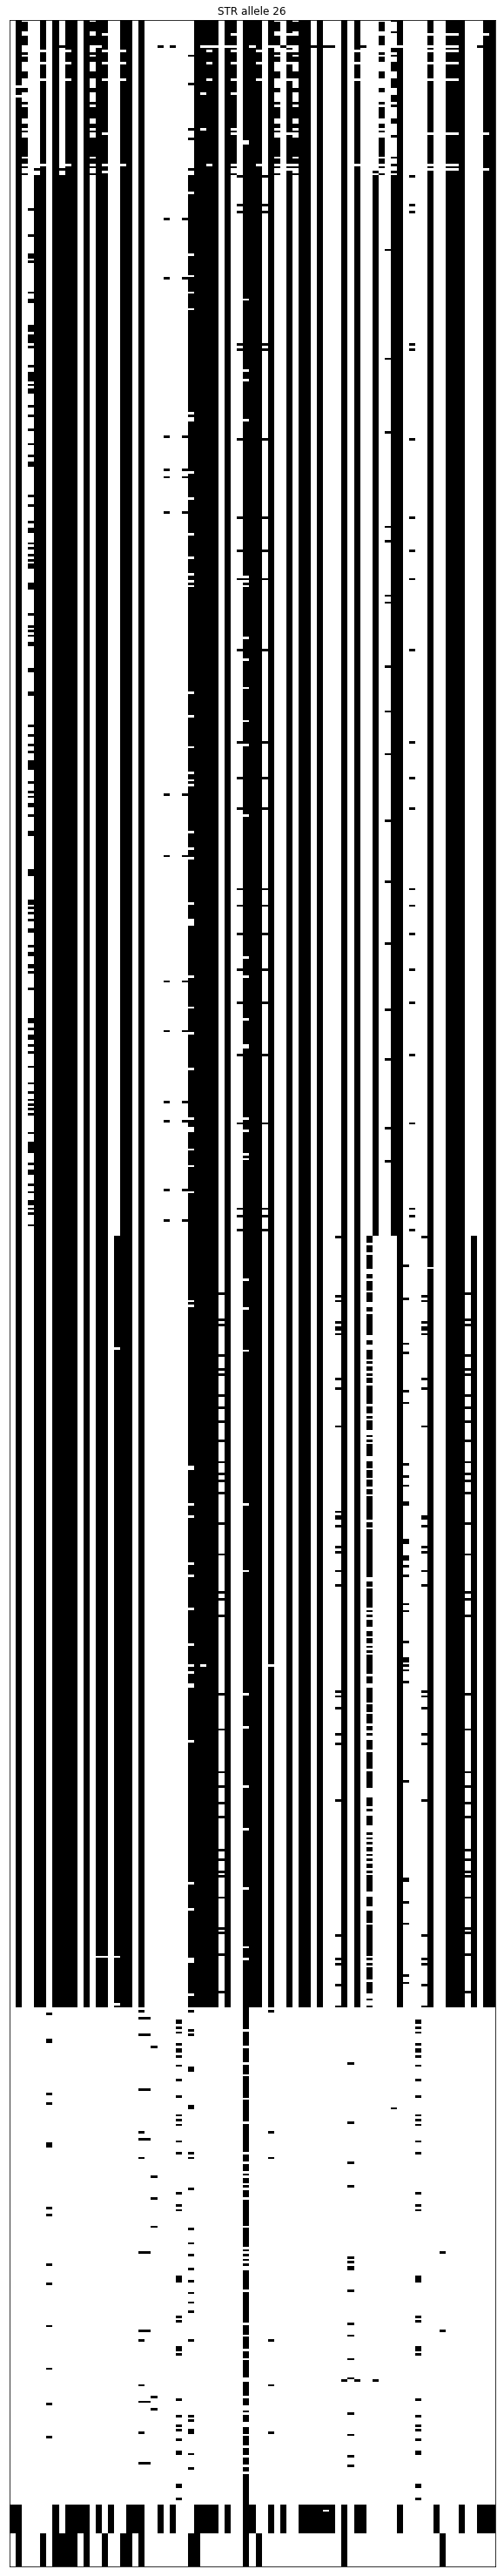

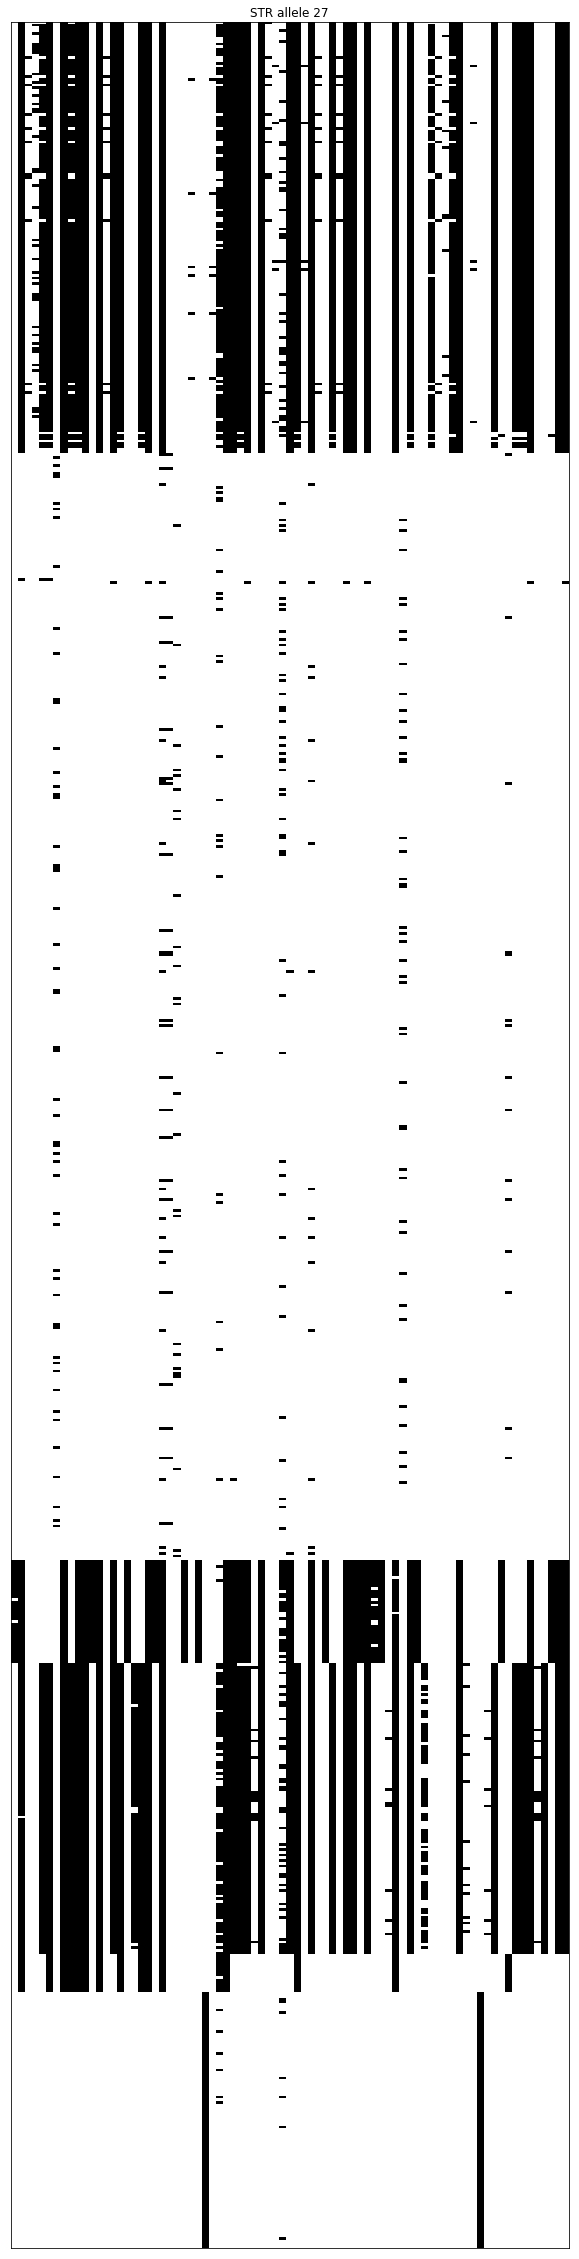

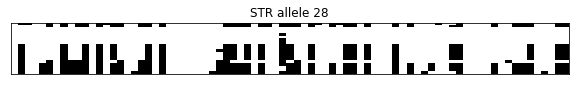

In [33]:
# SNP haplotypes per STR allele
for allele in sorted(list(set(strdata["STRallele"].values))):
    d = strdata[strdata["STRallele"]==allele]
    if d.shape[0] <= 1: continue
    hapmatrix = np.zeros((d.shape[0], len(d.SNPhaplotype.values[0])))
    for i in range(d.shape[0]):
        hapmatrix[i,:] = [int(item) for item in list(d.SNPhaplotype.values[i])]
    # Cluster rows
    hapmatrix_cl = ClusterRows(hapmatrix)[0]
    fig = plt.figure()
    fig.set_size_inches((10, d.shape[0]*0.05))
    ax = fig.add_subplot(111)
    ax.imshow(hapmatrix_cl, cmap='Greys', aspect="auto", extent=(0, hapmatrix_cl.shape[1], 0, hapmatrix_cl.shape[0]))
    ax.set_yticks([]);
    ax.set_yticklabels([]);
    ax.set_xticks([]);
    ax.set_xticklabels([]);
    ax.set_title("STR allele %s"%allele)

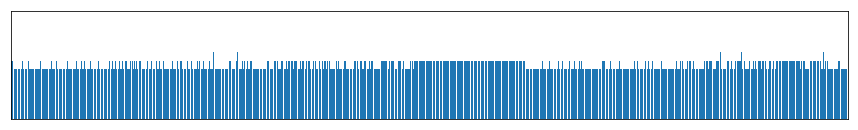

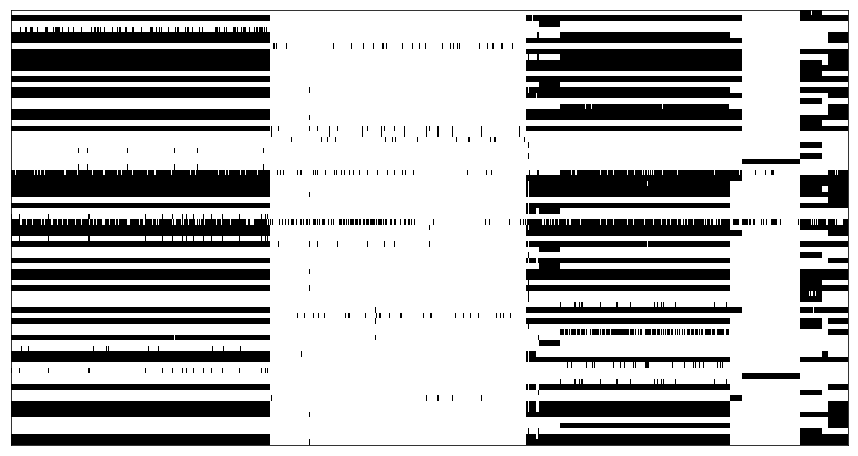

In [57]:
NCLUST=10
# all SNP haplotypes, annotate STR allele
d = strdata
hapmatrix = np.zeros((d.shape[0], len(d.SNPhaplotype.values[0])))
for i in range(d.shape[0]):
    hapmatrix[i,:] = [int(item) for item in list(d.SNPhaplotype.values[i])]
hapmatrix_cl, neworder, clusterids = ClusterRows(hapmatrix, nclusters=NCLUST)
def GetInt(x):
    try:
        return int(x)
    except: return 0 # "None" in allele column
stralleles = [GetInt(x) for x in np.array(d["STRallele"])[neworder]]

# To the top, plot str allele sizes
fig = plt.figure()
fig.set_size_inches((15, 2))
ax = fig.add_subplot(111)
ax.bar(range(len(stralleles)), stralleles)
ax.set_yticks([]);
ax.set_yticklabels([]);
ax.set_xticks([]);
ax.set_xticklabels([]);
ax.set_xlim(left=0, right=len(stralleles))
ax.set_ylim(bottom=min(stralleles)-5, top=max(stralleles)+5)

# Now print snp haplotypes (transpose)
fig = plt.figure()
fig.set_size_inches((15, 8))
ax = fig.add_subplot(111)
ax.imshow((hapmatrix_cl).transpose(), cmap='Greys', aspect="auto", extent=(0, hapmatrix_cl.shape[1], 0, hapmatrix_cl.shape[0]))
ax.set_yticks([]);
ax.set_yticklabels([]);
ax.set_xticks([]);
ax.set_xticklabels([]);

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


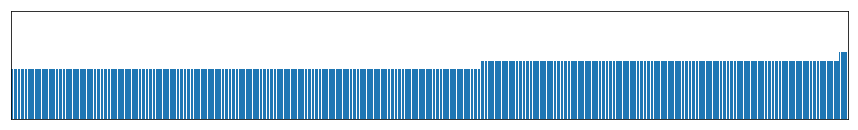

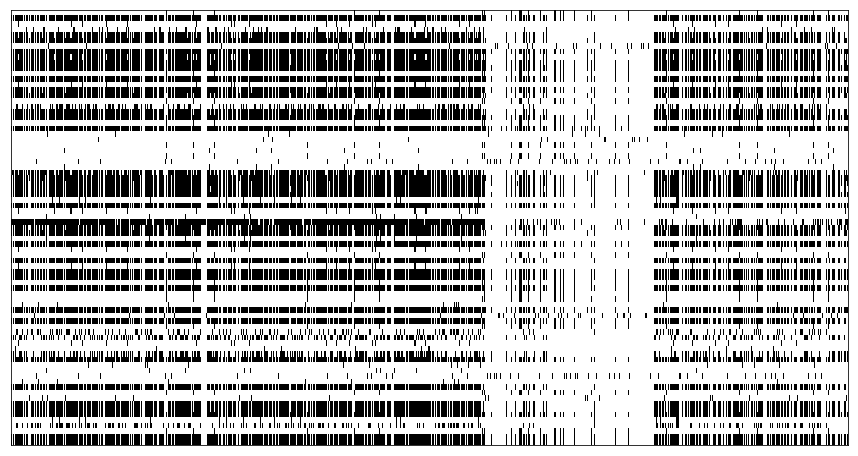

In [37]:
d = strdata.sort("STRallele")
hapmatrix = np.zeros((d.shape[0], len(d.SNPhaplotype.values[0])))
for i in range(d.shape[0]):
    hapmatrix[i,:] = [int(item) for item in list(d.SNPhaplotype.values[i])]
def GetInt(x):
    try:
        return int(x)
    except: return 0 # "None" in allele column
stralleles = [GetInt(x) for x in np.array(d["STRallele"])]

# To the top, plot str allele sizes
fig = plt.figure()
fig.set_size_inches((15, 2))
ax = fig.add_subplot(111)
ax.bar(range(len(stralleles)), stralleles)
ax.set_yticks([]);
ax.set_yticklabels([]);
ax.set_xticks([]);
ax.set_xticklabels([]);
ax.set_xlim(left=0, right=len(stralleles))
ax.set_ylim(bottom=min(stralleles)-5, top=max(stralleles)+5)

# Now print snp haplotypes (transpose)
fig = plt.figure()
fig.set_size_inches((15, 8))
ax = fig.add_subplot(111)
ax.imshow((hapmatrix).transpose(), cmap='Greys', aspect="auto", extent=(0, hapmatrix_cl.shape[1], 0, hapmatrix_cl.shape[0]))
ax.set_yticks([]);
ax.set_yticklabels([]);
ax.set_xticks([]);
ax.set_xticklabels([]);

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


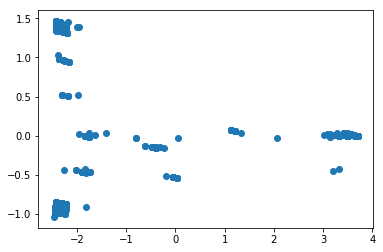

In [56]:
d = strdata.sort("STRallele")
hapmatrix = np.zeros((d.shape[0], len(d.SNPhaplotype.values[0])))
for i in range(d.shape[0]):
    hapmatrix[i,:] = [int(item) for item in list(d.SNPhaplotype.values[i])]
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(hapmatrix)
res = pca.transform(hapmatrix)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(res[:,0], res[:,1])

In [42]:
numsnps = len(strdata["SNPhaplotype"].values[0])
stralleles = set(strdata["STRallele"])
snpnum = []
strnum = []
r2vals = []
maf = []
for i in range(numsnps):
    snpgt = list(strdata["SNPhaplotype"].apply(lambda x: int(x[i])))
    for al in stralleles:
        strgt = [int(item==al) for item in strdata["STRallele"]]
        r2 = scipy.stats.pearsonr(snpgt, strgt)[0]**2
        snpnum.append(i)
        strnum.append(al)
        r2vals.append(r2)
        maf.append(np.mean(snpgt))
    # overall
    strgt = [int(item) for item in strdata["STRallele"]]
    r2 = scipy.stats.pearsonr(snpgt, strgt)[0]**2
    snpnum.append(i)
    strnum.append(0)
    r2vals.append(r2)
    maf.append(np.mean(snpgt))
ldinfo = pd.DataFrame({"snp": snpnum, "str": strnum, "r2": r2vals, "maf": maf})

In [43]:
ldinfo[["snp","str","r2","maf"]].head()

,snp,str,r2,maf
0,0,25,0.000027,0.025052
1,0,26,0.010133,0.025052
2,0,27,0.010923,0.025052
3,0,28,0.000257,0.025052
4,0,0,0.008813,0.025052


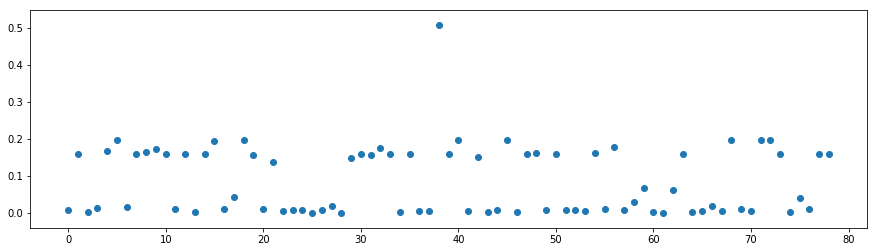

In [47]:
fig = plt.figure()
fig.set_size_inches((15, 4))
ax = fig.add_subplot(111)
x = ldinfo[ldinfo["str"]==0]
ax.scatter(x["snp"], x["r2"])
#for al in list(stralleles)+[0]:
#    x = ldinfo[ldinfo["str"]==al]
#    ax.scatter(x["snp"], x["r2"])